In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy
import seaborn as sns

In [2]:
business_data_to_load = "dataset/yelp_business.csv"
yelp_business_df = pd.read_csv(business_data_to_load)

In [3]:
yelp_business_df.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [4]:
yelp_business_df.drop(['business_id','neighborhood','latitude','longitude','is_open'], axis = 1, inplace = True)
yelp_business_df.head()

,name,address,city,state,postal_code,stars,review_count,categories
0,"""Dental by Design""","""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,4.0,22,Dentists;General Dentistry;Health & Medical;Or...
1,"""Stephen Szabo Salon""","""3101 Washington Rd""",McMurray,PA,15317,3.0,11,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,"""Western Motor Vehicle""","""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,1.5,18,Departments of Motor Vehicles;Public Services ...
3,"""Sports Authority""","""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,3.0,9,Sporting Goods;Shopping
4,"""Brick House Tavern + Tap""","""581 Howe Ave""",Cuyahoga Falls,OH,44221,3.5,116,American (New);Nightlife;Bars;Sandwiches;Ameri...


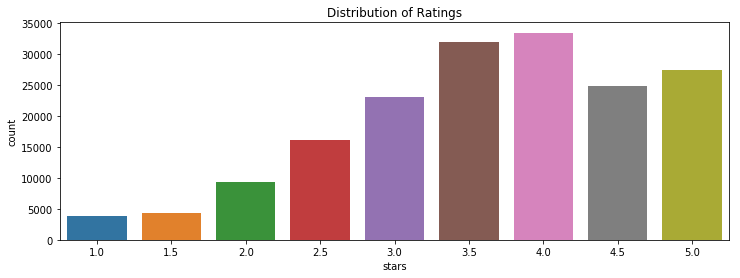

In [5]:
plt.figure(figsize=(12,4))
ax = sns.countplot(yelp_business_df['stars'])
plt.title('Distribution of Ratings');

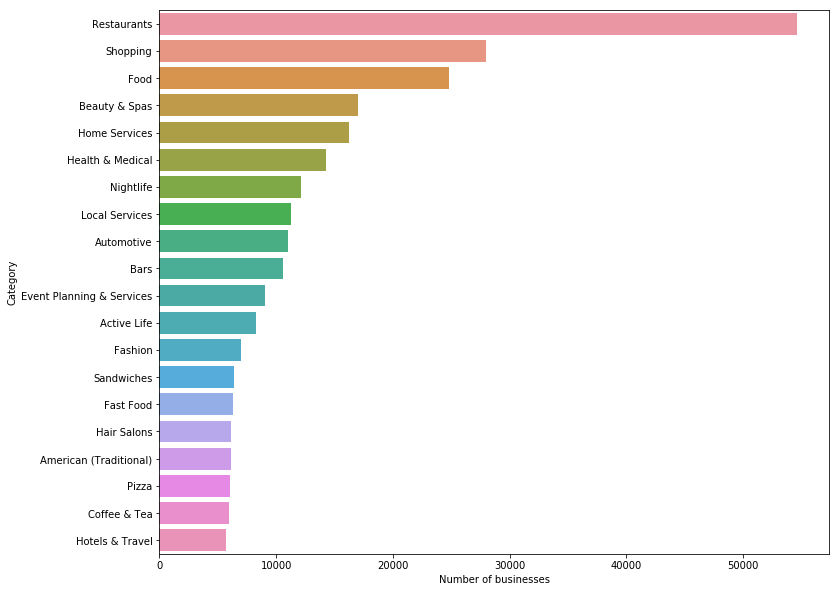

In [7]:
business_cats=';'.join(yelp_business_df['categories'])
cats=pd.DataFrame(business_cats.split(';'),columns=['category'])
cats_ser = cats.category.value_counts()

cats_df = pd.DataFrame(cats_ser)
cats_df.reset_index(inplace=True)

plt.figure(figsize=(12,10))
f = sns.barplot( y= 'index',x = 'category' , data = cats_df.iloc[0:20])
f.set_ylabel('Category')
f.set_xlabel('Number of businesses');